### **This notebook preprocesses features for the segmentation models**

In [ ]:
import importlib

import numpy as np
import pandas as pd
import seaborn as sns
from dotenv import load_dotenv
from sklearn.preprocessing import StandardScaler
load_dotenv(override=True)

from customer_segmentation.utils import db_utils, file_io, plot_utils, preprocessing
from customer_segmentation.constants import feature_groups as fg_const

modules_to_reload = [file_io, preprocessing, plot_utils, db_utils, fg_const]
for module in modules_to_reload:
    importlib.reload(module)


# Set pandas to display all columns
pd.set_option("display.max_columns", None)

**Load data from local db**

In [2]:
cohort = db_utils.read_from_db_to_df("customer_cohort_model_local", db_mode="local")

In [96]:
cohort.shape

(187268, 80)

**convert data & seperate binary and numeric values**

In [8]:
cohort["min_signup_date"] = pd.to_datetime(cohort["min_signup_date"])
cohort["user_id"] = cohort["user_id"].astype(str)
binary_cols = preprocessing.get_binary_columns(cohort)
numeric_cols = cohort.select_dtypes(include=[np.number]).columns.drop(binary_cols).to_list()

**Load feature groups relevant for the model**

In [9]:
feature_groups = fg_const.FEATURE_GROUPS
feature_groups

{'flight_discount_score': ['avg_flight_discount', 'flight_discount_rate'],
 'hotel_discount_score': ['avg_hotel_discount', 'hotel_discount_rate'],
 'user_score': ['age', 'is_married', 'has_children'],
 'engagement_score': ['days_last_trip',
  'sessions_per_month',
  'avg_session_duration_seconds',
  'page_click_per_session'],
 'flight_travel_score': ['avg_flight_travel_days',
  'avg_seats',
  'avg_checked_bags',
  'avg_distance_km',
  'flight_booked',
  'flight_booking_value'],
 'hotel_travel_score': ['avg_rooms',
  'avg_hotel_nights',
  'hotel_booked',
  'hotel_booking_value'],
 'cancellation_score': ['cancellation_rate']}

In [10]:
# extract features from dict
features = [item for items in feature_groups.values() for item in items]

### **Log-transform features**

**check features of skewness**

In [11]:
skewness = cohort[features].skew(numeric_only=True)
highly_skewed = skewness[np.abs(skewness) > 0.75].index.to_list()

highly_skewed

['avg_flight_discount',
 'flight_discount_rate',
 'avg_hotel_discount',
 'hotel_discount_rate',
 'days_last_trip',
 'sessions_per_month',
 'avg_session_duration_seconds',
 'page_click_per_session',
 'avg_flight_travel_days',
 'avg_seats',
 'avg_checked_bags',
 'avg_distance_km',
 'flight_booking_value',
 'avg_hotel_nights',
 'hotel_booking_value',
 'cancellation_rate']

In [ ]:
# log_names -> for log-transformed features
# feature_names -> for plotting
log_names = [item + "_log" for item in highly_skewed]
feature_names = [item for item in features if item in highly_skewed]

**Log-transform skewed features using `log1p` (handles 0 values)**

In [13]:
X_log = np.log1p(cohort[highly_skewed])
cohort[log_names] = X_log

**Explore log-transformed features**  
- especially metrics with a wide range of values (long tails) are compressed to a smaller scale

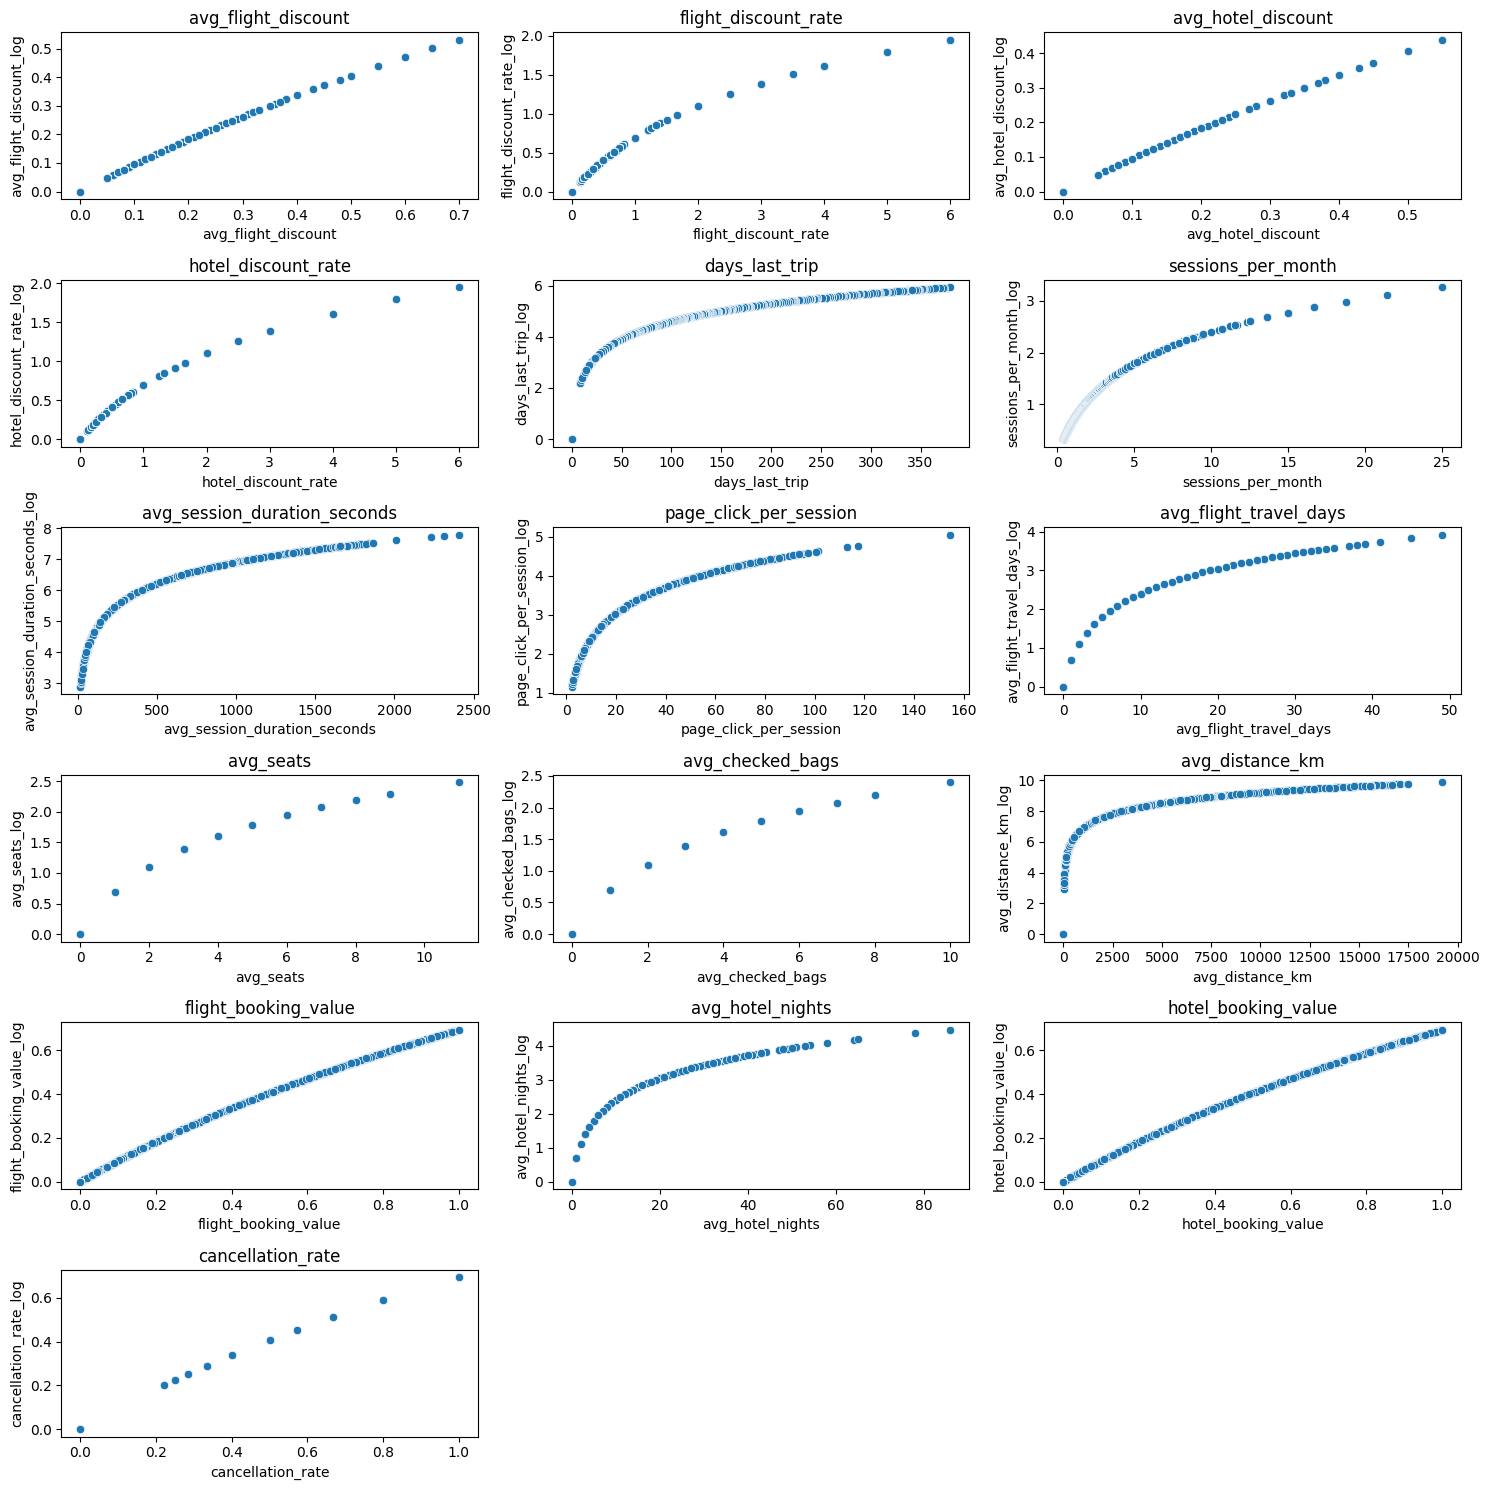

In [68]:
plot_utils.plot_relation_series(
    df=cohort,
    x=feature_names,
    y=log_names,
    n_cols=3,
    plot_type=sns.scatterplot,
    fig_height=15,
    fig_width=15,
)

### **Scaling features**

**scale log-transformed features, binary and approx. normal distributed features**

In [17]:
scale_names = []
feature_names = []
for feature in features:   
        if feature in highly_skewed:
            feature_name = feature + "_log"
        else:
            feature_name = feature 
        scale_name = feature + "_scaled"
        scale_names.append(scale_name)
        feature_names.append(feature_name)

In [18]:
feature_names

['avg_flight_discount_log',
 'flight_discount_rate_log',
 'avg_hotel_discount_log',
 'hotel_discount_rate_log',
 'age',
 'is_married',
 'has_children',
 'days_last_trip_log',
 'sessions_per_month_log',
 'avg_session_duration_seconds_log',
 'page_click_per_session_log',
 'avg_flight_travel_days_log',
 'avg_seats_log',
 'avg_checked_bags_log',
 'avg_distance_km_log',
 'flight_booked',
 'flight_booking_value_log',
 'avg_rooms',
 'avg_hotel_nights_log',
 'hotel_booked',
 'hotel_booking_value_log',
 'cancellation_rate_log']

**Apply `StandardScaler`:**  
subtracts mean from each observation, divided by standard deviation -> standardization (mean 0, std 1)
-> effect is centering the data

In [16]:
scaler = StandardScaler()
# for feature, score in zip(feature_names, score_names):
X_scaled = scaler.fit_transform(cohort[feature_names])
cohort[scale_names] = X_scaled

In [19]:
cohort[scale_names].agg(["mean", "std"]).round()

,avg_flight_discount_scaled,flight_discount_rate_scaled,avg_hotel_discount_scaled,hotel_discount_rate_scaled,age_scaled,is_married_scaled,has_children_scaled,days_last_trip_scaled,sessions_per_month_scaled,avg_session_duration_seconds_scaled,page_click_per_session_scaled,avg_flight_travel_days_scaled,avg_seats_scaled,avg_checked_bags_scaled,avg_distance_km_scaled,flight_booked_scaled,flight_booking_value_scaled,avg_rooms_scaled,avg_hotel_nights_scaled,hotel_booked_scaled,hotel_booking_value_scaled,cancellation_rate_scaled
mean,-0.0,0.0,0.0,-0.0,-0.0,-0.0,-0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.0,-0.0,0.0,-0.0,0.0,0.0,-0.0,0.0
std,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


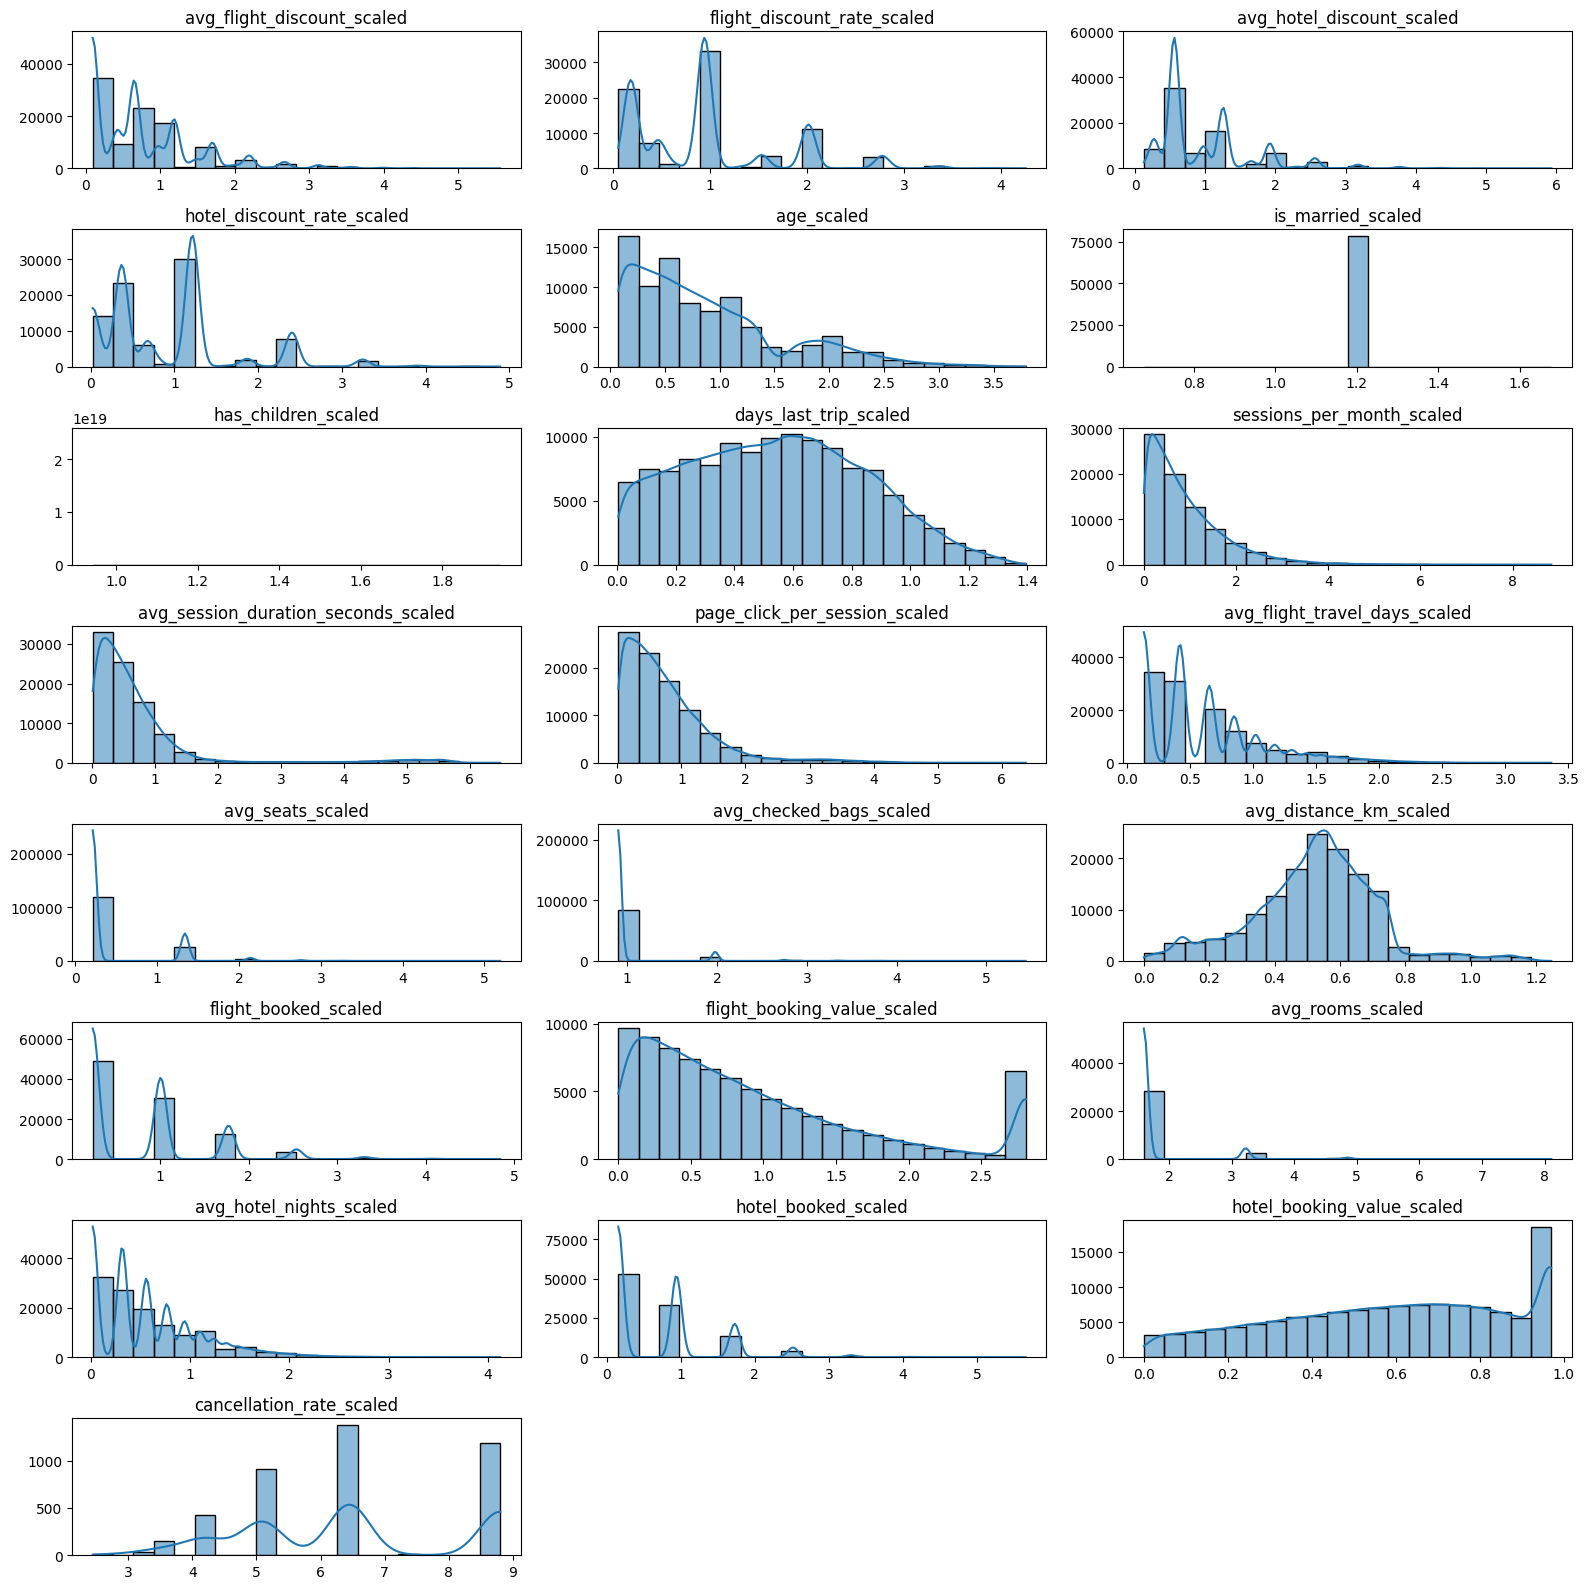

In [73]:
plot_utils.plot_univariate_series(
    df=cohort, metrics=list(scale_names), n_cols=3, plot_type=sns.histplot
)

**Apply PCA per thematic groups**

In [64]:
pca_info = {}
for score_name, features in feature_groups.items():
    features_scaled = [item + "_scaled" for item in features]  
    cohort, pca_info[score_name] = preprocessing.apply_PCA(
        df=cohort, features=features_scaled, score_name=score_name, n_components=1
    )

**Explore PCA results**  
Explained variance indicates how informatic is the score (share of total variance explained by first component)  
The components with the weights of the features contributing to main component  
> 0.7 -> strong effect of score (feature group is good represented by score)  
0.5 - 0.7 -> score is usable but with less information  
< 0.5 -> weak, either find more components or no reduction (as this score is not critical for modelling, it will be tested without the score)

In [91]:
rows = []
for name, (variance, components) in pca_info.items():
    row = {
        "score_name": name,
        "explained_variance_ratio": variance[0],
    }
    rows.append(row)
    for i, val in enumerate(components):
        row[f"component_{i+1}"] = val

pd.DataFrame(rows).round(2).fillna('')

,score_name,explained_variance_ratio,component_1,component_2,component_3,component_4,component_5,component_6
0,flight_discount_score,0.73,0.71,0.71,,,,
1,hotel_discount_score,0.78,0.71,0.71,,,,
2,user_score,0.48,0.68,0.71,0.17,,,
3,engagement_score,0.53,0.35,-0.26,0.63,0.64,,
4,flight_travel_score,0.65,0.45,0.46,0.31,0.48,0.37,0.34
5,hotel_travel_score,0.71,0.48,0.53,0.43,0.56,,
6,cancellation_score,1.00,1.00,,,,,


**Export log-transformed, scaled features and scores from PCA**

In [92]:
# extract scores
score_names = [col for col in cohort.columns if col.endswith("_score")]
features_filtered = [col for col in cohort.columns if col in scale_names or col in log_names or col in score_names or col == "user_id"]
cohort_filtered = cohort[features_filtered]

In [94]:
db_utils.execute_sql(sql_filename="create_customer_features")

Successfully executed create_customer_features.sql


In [95]:

db_utils.write_df_to_db(df=cohort_filtered, tablename="customer_features")